In [49]:
"""
Uses scikit-image, numpy, matplotlib and more packages to implement the Image class.
See documentation withing this class.
"""

from skimage.measure import shannon_entropy
import warnings
from skimage import color
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imsave
from skimage.morphology import disk
from skimage.filters.rank import mean
import skimage.filters.rank as skr
from numpy.fft import fft2,ifft2,fftshift,ifftshift
from skimage.restoration import estimate_sigma
from skimage.filters.rank import median
from skimage.filters import threshold_otsu
from tqdm import tqdm
from skimage.segmentation import watershed
from skimage.filters import gaussian, sobel
from sklearn.mixture import GaussianMixture
from skimage.transform import resize
from skimage import img_as_ubyte
from skimage.feature import graycomatrix, graycoprops



BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)

class Image:
    """
    The Image class is designed for advanced image processing and manipulation. It includes a variety of methods to modify and analyze images.

    Written by Alexandre Le Mercier on the 21th of November 2023.
    """

    def __init__(self, path_or_ndarray, chatty_mode=False):
        self.path_or_ndarray = path_or_ndarray

        if type(path_or_ndarray) == str:
            self.path = path_or_ndarray
            self.image = imread(self.path)
            self.image_save = imread(self.path)
            self.name = self.path[:-4]
        else:
            self.image = path_or_ndarray
            self.image_save = path_or_ndarray
            self.name = "Image of shape " + str(self.image.shape)

        self.width = self.image.shape[0]
        self.height = self.image.shape[1]
        self.get_iscolor() # init self.iscolor
        self.chatty = chatty_mode
        self.pipeline = []

    def __add__(self, other):
        self.check_size(other.image)
        new_image = self.image + other.image
        new = self
        new.image = new_image
        return new

    def __sub__(self, other):
        self.check_size(other.image)
        new_image = self.image - other.image
        new = self
        new.image = new_image
        return new

    def __mul__(self, other):
        self.check_size(other.image)
        new_image = self.image * other.image
        new = self
        new.image = new_image
        return new

    def __abs__(self):
        new_image = abs(self.image)
        new = self
        new.image = new_image
        return new

    def add_watermark(self, wm, rel_x, rel_y, wm_color=BLACK, alpha=1.0, spread=1.0):
        """
        Adds watermark with more features than before.
        :param wm: numpy.ndarray (watermark) or Image
        :param rel_x: float (percentage of total width)
        :param rel_y: float (percentage of total height)
        :param wm_color: tuple (RGB tuple for color)
        :param alpha: float (transparency)
        :param spread: float (modifies the scale of the watermark along with its density)
        """
        ancient_image = self.image
        self.get_iscolor()

        if type(wm) == Image:
            wm = wm.image

        wm_width, wm_height = wm.shape[0], wm.shape[1]
        bg_width, bg_height = self.image.shape[0], self.image.shape[1]

        x = rel_y * bg_width
        y = rel_x * bg_height

        # Very basic method to segment the watermark:
        wm_bg_limit = np.mean(wm)

        Wm = Image(wm)
        if self.iscolor:
            iterable = range(3)
            if not Wm.iscolor:
                Wm.gray_to_color()

        elif not self.iscolor and Wm.iscolor:
            self.gray_to_color()
            iterable = range(3)

        else:
            iterable = range(1)

        wm = Wm.image

        for pixel_color in self.get_iterable(iterable):
            for i in range(wm_width):
                for j in range(wm_height):
                    if wm[i, j, pixel_color] >= wm_bg_limit:

                        X = int(x + i * spread)
                        Y = int(y + j * spread)

                        try:
                            self.image[X, Y, pixel_color] \
                                = self.image[X, Y, pixel_color] * (1 - alpha) + wm_color[pixel_color] * alpha
                        except:

                            warnings.warn("Spread parameter is too large for the given image. Spread was ignored.")
                            spread = 1.0
                            X = int(x + i * spread)
                            Y = int(y + j * spread)
                            self.image[X, Y, pixel_color] \
                                = self.image[X, Y, pixel_color] * (1 - alpha) + wm_color[pixel_color] * alpha


        new_image = self.image
        self.image = ancient_image
        self.set_image(new_image, "add_watermark")



    def auto_enhance(self):
        """
        Automatically enhances the image by applying a series of image processing techniques
        such as histogram equalization, noise reduction, and auto-level adjustment.
        """
        if self.detect_noise():
            self.median_filter()

        self.equalize()

        self.gamma_correction(gamma=0.8)

        if len(self.image.shape) == 3:  # if not grayscale
            self.increase_saturation()

    def auto_level(self, size=5):
        """
        Applies auto-level adjustment to the image, enhancing contrast by redistributing the image intensity levels.
        :param size: int (size of the disk for local auto-level operation).
        """
        self.set_image(skr.autolevel(self.image, disk(size)), "auto_level")

    def check_size(self, other_image):
        if self.image.shape != other_image.shape:
            raise AttributeError(
                f"Both images must have the same size, but image 1 has {self.image.shape} but image 2 {other_image.shape}.")

    def color_to_gray(self):
        self.get_iscolor()
        if self.iscolor:
            self.set_image(color.rgb2gray(self.image), "color_to_gray")
        else:
            warnings.warn(f"color_to_gray: image {self.name} is already grayscale. Skip.")


    def detect_noise(self, noisy_threshold=0.01):
        """
        Detects noise in the image by estimating the noise standard deviation across color channels.
        :param noisy_threshold: float (value from which we consider the image as noisy)
        """
        self.get_iscolor()
        if self.iscolor:
            sigma_est = estimate_sigma(self.image, average_sigmas=True, channel_axis=-1)
        else:
            sigma_est = estimate_sigma(self.image, average_sigmas=True)

        isnoisy = sigma_est > noisy_threshold
        self.user_message(f"The image was estimated noisy (estimated sigma {round(sigma_est, 3)} > threshold {noisy_threshold}).", isnoisy)

        return isnoisy

    def downsample_image(self, factor=2):
        """
        Downsamples the image by taking every nth pixel according to the factor.

        :param im: numpy.ndarray (the input image to downsample).
        :param factor: int (the downsampling factor).
        :return: numpy.ndarray (the downsampled image).
        """
        if factor < 2 or not isinstance(factor, int):
            raise ValueError(
                f"Error in Image.downsample_image: downsampling factor must be an integer greater than 1, but {factor} was given.")

        return self.image[::factor, ::factor]

    def equalize(self):
        """
         Performs histogram equalization on the image to enhance contrast. This is useful in improving the visibility
         of features in images with poor contrast.
         """
        image = self.image
        hist, _ = np.histogram(image.flatten(), 256, [0, 256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * float(
            hist.max()) / cdf.max()  # Normalizes the CDF so that the highest value is scaled to the peak value of the histogram
        cdf_m = np.ma.masked_equal(cdf_normalized, 0)  # to avoid division by zero error
        cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
        cdf = np.ma.filled(cdf_m, 0).astype('uint8')  # replace the withdrawn values
        self.set_image(cdf[image], "equalize")

    def extract_rgb(self):
        return self.image[:, :, 0], self.image[:, :, 1], self.image[:, :, 2]

    def gamma_correction(self, gamma=1.7):
        """
        Applies gamma correction to the image. This can be used to adjust the brightness and contrast of the image.
        :param gamma: float (gamma value for the correction, higher values darken the image, lower values brighten it).
        """
        lut = np.power(np.arange(256) / 255.0, gamma) * 255
        self.set_image(lut[self.image.astype(np.uint8)].astype(np.uint8), "gamma_correction")


    def gaussian_mixture_segmentation(self, iterations=100, zones=4, return_areas=False):
        """
        Uses the clustering method "Gaussian Mixture" to segment the zones.
        :param iterations: number of maximum iterations of the algorithm
        :param zones: number of zones to segment
        """

        if self.iscolor:
            self.color_to_gray()
            self.user_message("Cannot apply gaussian mixture to colored image. Grayscale conversion was automatically performed.")

        image_flattened = self.image.flatten().reshape(-1, 1)

        gmm = GaussianMixture(n_components=zones, max_iter=iterations)

        # Fit the GMM model only on the non-zero, masked pixels
        gmm.fit(image_flattened)

        # Predict the segmentation on the non-zero, masked pixels
        segmented = gmm.predict(image_flattened)

        segmented_image = segmented.reshape(self.image.shape)

        self.set_image(segmented_image, "gaussian mixture segmentation")

        if return_areas:
            areas = list()
            for i in range(zones):
                area = np.sum(segmented == i)
                areas.append(area)
                self.user_message(f"Area of cluster {i}: {area} pixels")
            return areas


    def get_descriptors(self, region, displacements, angles, props):
        glcm = graycomatrix(region, displacements, angles, 256, normed=True, symmetric=True)
        descriptors = []
        for prop in props:
            descriptors += [graycoprops(glcm, prop)]
        return np.array(descriptors).flatten()

    def get_iscolor(self):
        """
        Verifies the self.iscolor statement. This function was created because of the various operations on images
        that could change self.iscolor without being sure that the class object has noticed it. "get_iscolor" is hence
        an additional security measure.
        """
        if len(self.image.shape) > 2:
            self.iscolor = True
        else:
            self.iscolor = False

    def get_iterable(self, iterable):
        return tqdm(iterable) if self.chatty else iterable

    def gray_to_color(self):
        """
        Converts a single-channel grayscale image into a 3-channel RGB image by replicating the grayscale values across the RGB channels.

        :param gray_image: numpy.ndarray
            A 2D numpy array representing the grayscale image.

        :return: numpy.ndarray
            A 3D numpy array where the grayscale values have been replicated across three channels to create an RGB image.
        """
        self.get_iscolor()
        if self.iscolor:
            warnings.warn(f"gray_to_color: image {self.name} is already colored. Skip.")
            return

        # Replicate the single channel across all three RGB channels
        color_image = np.array(np.stack((self.image,) * 3, axis=-1))
        self.set_image(color_image, "gray_to_color")
        if not self.iscolor:
            raise AssertionError(f"Something went wrong wile transforming {self.name} in grayscale.")


    def graycomatrix_segmentation(self, angles = [0, np.pi/6, np.pi/3, np.pi/2, 2*np.pi/3, 5*np.pi/6], displacements = [1, 2, 3], props = ['dissimilarity'], n_cells_x=None, n_cells_y=None):

        n_cells_x = self.image.shape[0] if n_cells_x == None else n_cells_x
        n_cells_y = self.image.shape[1] if n_cells_y == None else n_cells_y

        size_x = self.image.shape[0] // n_cells_x
        size_y = self.image.shape[1] // n_cells_y

        descriptors = np.zeros((n_cells_y, n_cells_x, len(angles)*len(displacements)*len(props)))

        self.color_to_gray()

        # Scale grayscale image to 8-bit and convert to uint8
        imgray_8bit = img_as_ubyte(self.image)

        for y in self.get_iterable(range(n_cells_y)):
            for x in range(n_cells_x):
                # Ensure the slicing indices are within the image dimensions
                y_start = min(y * size_y, imgray_8bit.shape[0] - 1)
                y_end = min((y + 1) * size_y, imgray_8bit.shape[0])
                x_start = min(x * size_x, imgray_8bit.shape[1] - 1)
                x_end = min((x + 1) * size_x, imgray_8bit.shape[1])

                region = imgray_8bit[y_start:y_end, x_start:x_end]
                descriptors[y, x] = self.get_descriptors(region, displacements, angles, props)

        ndescriptors = (descriptors - descriptors.mean()) / descriptors.std()

        new_images = [Image(ndescriptors[:, :, i], chatty_mode=self.chatty) for i in range(ndescriptors.shape[2])]

        return new_images


    def grow_square(self):
        """
        Turns a rectangular-shaped image into a squared-shape image.
        """
        if self.width == self.height:
            warnings.warn("The image is already squared. Can't perform 'grow_square' method.")
            return

        delta = abs(self.height - self.width)
        if self.height < self.width:
            padding = ((0, 0), (0, delta), (0, 0)) if self.iscolor else ((0, 0), (0, delta))
        else:
            padding = ((0, delta), (0, 0), (0, 0)) if self.iscolor else ((0, delta), (0, 0))

        square_image = np.pad(self.image, padding, mode='edge')
        self.set_image(square_image, "grow_square")


    def help(self):
        """
        Interactive help menu for the Image class that guides users to appropriate methods based on their needs.
        """
        menu = """
    Welcome to the help menu of Image. What would you like to do with your image?
        a) Segmentation
        b) Add watermark
        c) Preprocess
        d) View image
        e) Save image
    (type "exit" to leave)
        """
        print(menu)
        choice = input("Please choose an option: ").lower()
        while choice != 'exit':
            if choice == 'a':
                print(
                    "For segmentation, you can use methods like 'gaussian_mixture_segmentation', 'otsu_threshold', 'optimal_threshold', 'region_growing' or 'texture_segmentation'.")
            elif choice == 'b':
                print("To add a watermark, use the 'add_watermark' method.")
            elif choice == 'c':
                print(
                    "For preprocessing, methods such as 'auto_enhance', 'mean_filter', and 'median_filter' are available.")
            elif choice == 'd':
                print("To view the image, use the 'show' method.")
            elif choice == 'e':
                print("To save changes to the image, use the 'save' method.")
            else:
                print("Invalid option, please try again.")

            print(menu)
            choice = input("Please choose an option: ").lower()

    def increase_saturation(self, factor=1.2):
        """
        Increases the color saturation of the image.
        :param factor: float (factor by which to increase the saturation).
        """
        hsv_image = color.rgb2hsv(self.image)
        hsv_image[:, :, 1] *= factor
        hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1], 0, 1)  # Ensure saturation remains in valid range
        self.set_image(color.hsv2rgb(hsv_image), "increase_saturation")

    def inverse(self):
        """
        Inverts the colors of the image, which can be useful for analyzing details that are hard to see in the
        original color scheme.
        """
        invert_lut = np.array([255 - i for i in range(256)])
        self.set_image(invert_lut[self.image], "inverse")


    def mean_filter(self, size=2):
        """
        Applies a mean filter to the image, which is useful for noise reduction and smoothing.
        If the image is in color, the filter is applied to each channel separately.
        :param size: int (size of the mean filter kernel).
        """
        self.get_iscolor()
        if not self.iscolor:
            self.set_image(mean(self.image, disk(size)), "mean_filter")
        else:
            for i in self.get_iterable(range(3)):  # Assuming the image has 3 channels (RGB)
                self.image[:, :, i] = mean(self.image[:, :, i], disk(size))

    def median_filter(self, size=2):
        """
        Applies a median filter to the image, effective in reducing salt-and-pepper noise while preserving edges.
        If the image is in color, the filter is applied to each channel separately.
        :param size: int (size of the median filter kernel).
        """
        self.get_iscolor()
        if not self.iscolor:
            self.set_image(median(self.image, disk(size)), "median_filter")
        else:
            for i in self.get_iterable(range(3)):  # Assuming the image has 3 channels (RGB)
                self.image[:, :, i] = median(self.image[:, :, i], disk(size))


    def optimal_threshold(self, initial_threshold=128, tolerance=1):
        """
        Find the threshold for an image using an iterative algorithm.

        :param initial_threshold: float, the initial guess for the threshold
        :param tolerance: float, the convergence tolerance
        :return: float, the found threshold
        """
        T = initial_threshold
        while True:
            # Step 2: Divide pixels into two groups based on the threshold
            G1 = self.image[self.image > T]
            G2 = self.image[self.image <= T]

            # Step 3: Compute mean (centroid) of each group
            m1 = np.mean(G1) if len(G1) > 0 else 0
            m2 = np.mean(G2) if len(G2) > 0 else 0

            # Step 4: Compute new threshold
            T_new = (m1 + m2) / 2

            threshold_lut = np.array([i if i >= T else 0 for i in range(256)])
            self.set_image(threshold_lut[self.image], "optimal_threshold")

            # Check for convergence
            if np.abs(T - T_new) < tolerance:
                break
            T = T_new

    def otsu_threshold(self):
        """
        Applies Otsu's thresholding to the image to convert it to a binary image where the threshold is determined automatically.
        """
        th = threshold_otsu(self.image)
        self.set_image(self.image > th, "otsu_threshold")
        self.get_iscolor()

    def reduce(self, reduction_factor=2):
        """
        Reduces the number of gray levels in the image, which can be useful for reducing image size and
        emphasizing certain features.
        :param reduction_factor: int (factor by which to reduce the gray levels).
        """
        reduced_lut = np.array([i // reduction_factor for i in range(256)])
        self.set_image(reduced_lut[self.image], "reduce")

    def reduce_dithering(self, fourier_filter_radius=20):
        """
        Reduces dithering noise in the image by applying a Fourier transform-based filter. This is useful for
        cleaning up images with dithering artifacts.
        :param fourier_filter_radius: int (radius for the Fourier filter).
        """
        f = fftshift(fft2(self.image))  # shift Fourier image so that the center corresponds to low frequencies
        for x in self.get_iterable(range(len(f))):
            for y in range(len(f[x])):
                f[x, y] = f[x, y] * self.round_mask(x, y, fourier_filter_radius, center=True)

        self.fourier_amplitute = np.sqrt(np.real(f) ** 2 + np.imag(f) ** 2)
        self.set_image(ifft2(ifftshift(f)).real, "reduce_dithering")


    def region_growing(self, sigma=1, markers_coordinates=None):
        """
        Segments the image into regions using the watershed algorithm with specified markers.
        Applies Gaussian blur followed by Sobel edge detection to prepare the image.

        :param sigma: float, standard deviation for Gaussian blur.
        :param markers_coordinates: list of tuples, coordinates for markers.
        :return: None, modifies the image in-place.
        """
        # Convert to grayscale if the image is colored
        self.get_iscolor()
        if self.iscolor:
            self.color_to_gray()

        # Apply Gaussian blur and Sobel edge detection
        smoothed = gaussian(self.image, sigma=sigma)
        edges = sobel(smoothed)

        # Default marker coordinates
        if markers_coordinates is None:
            w4, h4 = self.width // 4, self.height // 4
            markers_coordinates = [[w4, h4], [3*w4, h4], [h4, 3*h4], [3*w4, 3*h4]]

        # Create markers
        markers = np.zeros_like(self.image, dtype=np.int)
        for i, (row, col) in enumerate(markers_coordinates):
            markers[row, col] = i + 1

        # Apply watershed
        segmented_image = watershed(edges, markers)
        if self.iscolor:
            # For color images, we keep the original colors where segmentation occurred
            self.set_image(color.label2rgb(segmented_image, self.image, kind='overlay'), "region_growing")
        else:
            self.set_image(segmented_image, "region_growing")


    def reset(self):
        """
        Resets the image to its original state.
        """
        try:
            self.name = self.path[0:-4]
        except:
            Warning("Cannot reset the name")
        self.set_image(self.image_save, "reset")
        self.pipeline = []

    def resize_to(self, output_shape, order=0):
        self.set_image(resize(self.image, output_shape, order=order), "resize_to")

    def round_mask(self, x, y, radius_lim, center=False):
        if center:
            x0, y0 = self.image.shape[0] // 2, self.image.shape[1] // 2
        else:
            x0, y0 = 0, 0

        x, y = x - x0, y - y0
        radius = np.sqrt(x ** 2 + y ** 2)
        return int((radius <= radius_lim))


    def save(self):
        """
        Saves the updated image file.
        """
        imsave(self.name, self.image)

    def save_image_data(self, filename):
        """
        Saves the np.ndarray of the image in an external text file in Python list format.
        :param image: np.ndarray of the image data
        :param filename: The name of the file where to save the data
        """
        with open(filename, 'w', encoding='utf-8') as file:
            image_list = self.image.tolist()
            file.write(str(image_list))


    def set_image(self, new_image, method=None):
        """
        Safe way to change self.image
        :param new_image: the new self.image
        :param method: the method that changed the image
        """
        self.image = new_image
        self.get_iscolor()
        if self.iscolor:
            self.width, self.height, self.colors = self.image.shape
        else:
            self.width, self.height = self.image.shape

        if not method:
            self.user_message(f"Image array was updated. Shape is {self.image.shape}.")
        else:
            self.user_message(f"Image array was updated by method \"{method}\".")
            self.pipeline.append(method)



    def show(self, size=6, title='', x_axis='', y_axis='', type_of_plot='rgb', subplots=(0, 0, 0), grayscale=False,
             normalize=False, axis=False, threshold=None, colorbar=False, alpha=1, show=True, cmap='gray'):
        """
        Shortcut function to execute commands often used to plot functions and show images.
        :param size: int if square or bool if rectangle
        :param title: str
        :param x_axis: str
        :param y_axis: str
        :param type_of_plot: 'rgb' for showing the rgb image, 'hist' for histograms
        :param subplots: tuple (a, b, c) for matplotlib's subplots
        :param grayscale: bool
        :param normalize: bool  (for histograms only)
        :param threshold: float (draws a red line in the histogram)
        :return: shows the plot (no return value).
        """

        self.get_iscolor()

        if len(subplots) != 3 and subplots != (0, 0, 0):
            raise AttributeError("'subplots' must contain 3 values")

        if subplots[2] == (1 or 0):
            if type(size) == int:
                plt.figure(figsize=(size, size))
            elif type(size) == tuple:
                plt.figure(figsize=size)
            else:
                raise AttributeError("'Size' must be either an integer or a tuple")

        if subplots != (0, 0, 0):
            a, b, c = subplots
            plt.subplot(a, b, c)
        plt.title(title)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)

        if type_of_plot == 'rgb':
            if title == '':
                plt.title(self.name)
            if not self.iscolor:
                plt.imshow(self.image, cmap=cmap, alpha=alpha)
            elif grayscale:
                self.color_to_gray()
                self.get_iscolor()
                if self.iscolor == True:
                    raise AssertionError("Something went wrong with rgb2gray: the image is still rgb.")
                plt.imshow(self.image, cmap=cmap, alpha=alpha)
            else:
                plt.imshow(self.image, alpha=alpha)
        elif type_of_plot == 'hist':
            if not self.iscolor:
                if title == '':
                    plt.title("Histogram of grayscale intensities")
                hist, _ = np.histogram(self.image, bins=256, range=(0, 255))
                if normalize:
                    hist /= hist.sum()
                plt.plot(hist)
                if threshold != None:
                    plt.plot([threshold, threshold], [0, hist.max()], 'r-')
            else:
                if title == '':
                    plt.title("Histogram of RGB values")
                r, g, b = self.extract_rgb()
                r = r.flatten()
                g = g.flatten()
                b = b.flatten()
                rhist, _ = np.histogram(r, bins=256, range=(0, 255))
                ghist, _ = np.histogram(g, bins=256, range=(0, 255))
                bhist, _ = np.histogram(b, bins=256, range=(0, 255))
                if normalize:
                    rhist = rhist / np.sum(rhist)
                    ghist = ghist / np.sum(ghist)
                    bhist = bhist / np.sum(bhist)
                plt.plot(rhist, color='red', label='Red')
                plt.plot(ghist, color='green', label='Green')
                plt.plot(bhist, color='blue', label='Blue')
                plt.legend()
                if threshold != None:
                    plt.plot([threshold, threshold], [0, rhist.max()], 'r-')
        else:
            raise AttributeError("'type_of_plot' must be either 'rgb' or 'hist'.")

        if not axis:
            plt.axis('off')

        if colorbar:
            plt.colorbar()

        self.user_message(f"Pipeline of the image displayed below is: {self.pipeline}")

        if subplots[2] == subplots[0] * subplots[1] and show:
            plt.show()



    def sliding_window(self, PATCH_SIZE, method='max', return_mask=False):
        """
        Applies a sliding window technique over the image to compute a texture descriptor for each window.

        The function moves the patch across the image and computes the descriptor defined by the 'method' parameter for each position.

        :param PATCH_SIZE: A tuple of two integers (height, width) specifying the size of the patch for the sliding window.
        :param method: A string specifying the method of texture descriptor calculation. Accepted values are 'max' or 'entropy'.
        :param return_mask: True if the user only wants to extract the mask
        :return: The mask if "return_mask" is set on "True" or nothing otherwise (directly modifies the image)
        :raises AttributeError: If an invalid method argument is passed.
        """
        im = self.image
        output = np.zeros((im.shape[0], im.shape[1]))
        for i in self.get_iterable(range(0, im.shape[0] - PATCH_SIZE[0] + 1, PATCH_SIZE[0])):
            for j in range(0, im.shape[1] - PATCH_SIZE[1] + 1, PATCH_SIZE[1]):
                patch = im[i:i + PATCH_SIZE[0], j:j + PATCH_SIZE[1]]
                if method == 'max':
                    output[i:i + PATCH_SIZE[0], j:j + PATCH_SIZE[1]] = self.texture_descriptor_max(patch)
                elif method == 'entropy':
                    output[i:i + PATCH_SIZE[0], j:j + PATCH_SIZE[1]] = self.texture_descriptor_entropy()
                else:
                    return AttributeError(
                        f"Error in Image.sliding_windows: method argument should be 'max' or 'entropy' but {method} was given.")

        if return_mask:
            return Image(output)
        else:
            self.set_image(output, "sliding_window")
            self.get_iscolor()


    def stretch(self, T_min, T_max):
        """
        Stretches the histogram of the image between specified minimum and maximum values, which enhances the
        contrast in a specific intensity range.
        :param T_min: int (minimum threshold for stretching).
        :param T_max: int (maximum threshold for stretching).
        """
        stretched_lut = np.array(
            [0 if i < T_min else 255 if i > T_max else ((i - T_min) / (T_max - T_min)) * 255 for i in range(256)])
        self.set_image(stretched_lut[self.image], "stretch")


    def texture_descriptor_entropy(self):
        """
        Computes the Shannon entropy of the image as a texture descriptor.
        Entropy measures the randomness in the image which can be used as a proxy for texture complexity.

        :return float: The entropy of the image.
        """
        return shannon_entropy(self)


    def texture_descriptor_max(self, patch):
        """
        Computes the maximum value in a given patch of the image as a texture descriptor.
        This simple approach captures the highest intensity present in the patch.

        :param patch (numpy.ndarray): The image patch for which to compute the maximum value descriptor.

        :return:  float: The maximum value in the patch.
        """
        e = patch.max()
        return e


    def texture_segmentation(self, patch_size=(3, 3), method='max'):
        """
        Segments the image based on texture using a specified texture descriptor and segmentation method.

        :param patch_size: (tuple of int): The size of the patches to be used for texture descriptor computation.
        :param method (str): The method used for texture descriptor calculation, 'max' for maximum value or 'entropy'.
        """
        if type(patch_size) == int:
            patch_size = (patch_size, patch_size)

        self.sliding_window(patch_size, method=method)
        self.otsu_threshold()


    def threshold(self, threshold):
        """
         Applies thresholding to the image, setting all pixels below the threshold to zero. This is useful for
         segmenting or emphasizing certain features in the image.
         :param threshold: int (threshold value).
         """
        threshold_lut = np.array([i if i >= threshold else 0 for i in range(256)])
        self.set_image(threshold_lut[self.image], "threshold")


    def user_message(self, message, condition=True):
        """
        Sends a message to the console for the user if chatty mode is activated for this image
        :param message: The message to display (if chatty mode is activated)
        :param condition: The optional condition to display this message
        """
        if self.chatty and condition:
            print(f"Image \"{self.name}\": " + message)


100%|██████████| 3/3 [00:00<00:00, 14.56it/s]


Image "Pictures/nyc": Image array was updated by method "add_watermark".


100%|██████████| 3/3 [00:00<00:00, 14.67it/s]


Image "Pictures/nyc": Image array was updated by method "add_watermark".


  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\allem\AppData\Local\Temp\ipykernel_19104\658426107.py:141: UserWarning: Spread parameter is too large for the given image. Spread was ignored.
  warnings.warn("Spread parameter is too large for the given image. Spread was ignored.")
100%|██████████| 3/3 [00:00<00:00, 13.76it/s]


Image "Pictures/nyc": Image array was updated by method "add_watermark".


100%|██████████| 3/3 [00:00<00:00, 15.07it/s]


Image "Pictures/nyc": Image array was updated by method "add_watermark".
Image "Pictures/nyc": Pipeline of the image displayed below is: ['add_watermark', 'add_watermark', 'add_watermark', 'add_watermark']


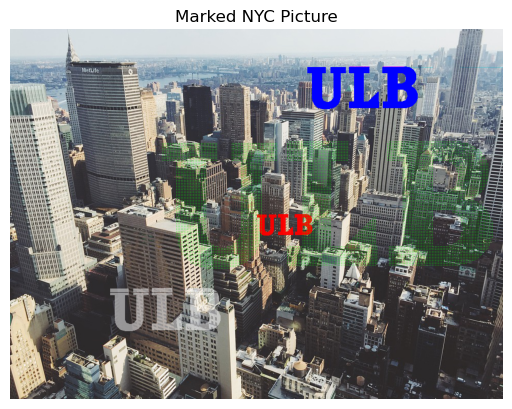

In [9]:
path_to_nyc, path_to_watermark = 'Pictures/nyc.jpg', 'Pictures/watermark.png'

background_image = Image(path_to_nyc, chatty_mode=True)
watermark = Image(path_to_watermark, chatty_mode=True)

background_image.add_watermark(watermark, 0.5, 0.5, wm_color=RED, alpha=0.55, spread=0.5)
background_image.add_watermark(watermark, 0.2, 0.7, wm_color=WHITE, alpha=0.5, spread=1)
background_image.add_watermark(watermark, 0.6, 0.1, wm_color=BLUE, alpha=1, spread=2)
background_image.add_watermark(watermark, 0.3, 0.3, wm_color=GREEN, alpha=1, spread=3)
background_image.show(title="Marked NYC Picture")

Image "Pictures/zebra": Pipeline of the image displayed below is: []
Image "Pictures/zebra": The image was estimated noisy (estimated sigma 3.034 > threshold 0.01).


100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Image "Pictures/zebra": Image array was updated by method "equalize".
Image "Pictures/zebra": Image array was updated by method "gamma_correction".
Image "Pictures/zebra": Image array was updated by method "increase_saturation".
Image "Pictures/zebra": Pipeline of the image displayed below is: ['equalize', 'gamma_correction', 'increase_saturation']


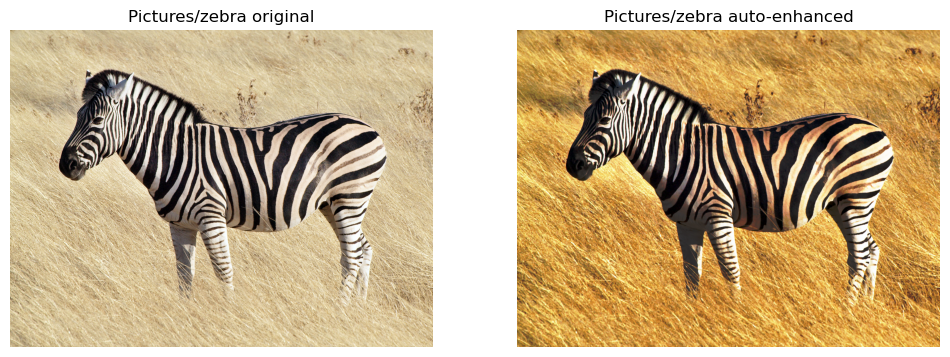

Image "Pictures/astronaut_noisy": Pipeline of the image displayed below is: []
Image "Pictures/astronaut_noisy": The image was estimated noisy (estimated sigma 26.888 > threshold 0.01).
Image "Pictures/astronaut_noisy": Image array was updated by method "median_filter".
Image "Pictures/astronaut_noisy": Image array was updated by method "equalize".
Image "Pictures/astronaut_noisy": Image array was updated by method "gamma_correction".
Image "Pictures/astronaut_noisy": Pipeline of the image displayed below is: ['median_filter', 'equalize', 'gamma_correction']


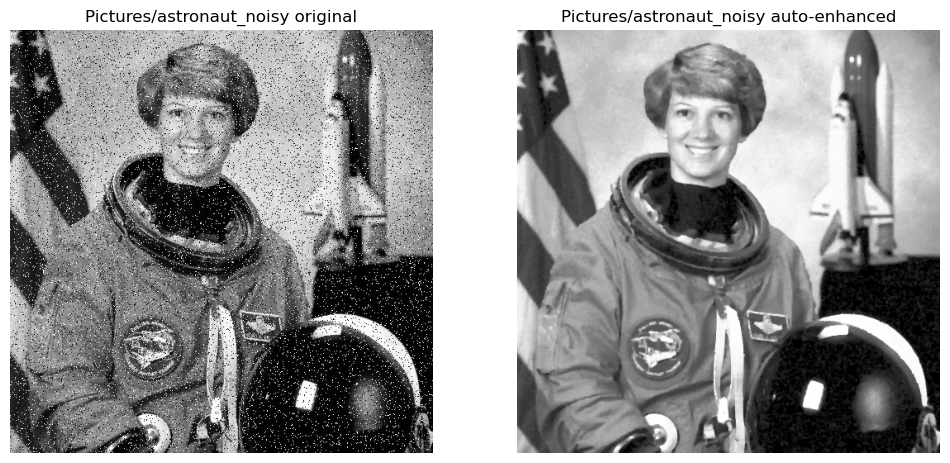

Image "Pictures/nyc": Pipeline of the image displayed below is: []
Image "Pictures/nyc": The image was estimated noisy (estimated sigma 4.993 > threshold 0.01).


100%|██████████| 3/3 [00:00<00:00,  7.95it/s]


Image "Pictures/nyc": Image array was updated by method "equalize".
Image "Pictures/nyc": Image array was updated by method "gamma_correction".
Image "Pictures/nyc": Image array was updated by method "increase_saturation".
Image "Pictures/nyc": Pipeline of the image displayed below is: ['equalize', 'gamma_correction', 'increase_saturation']


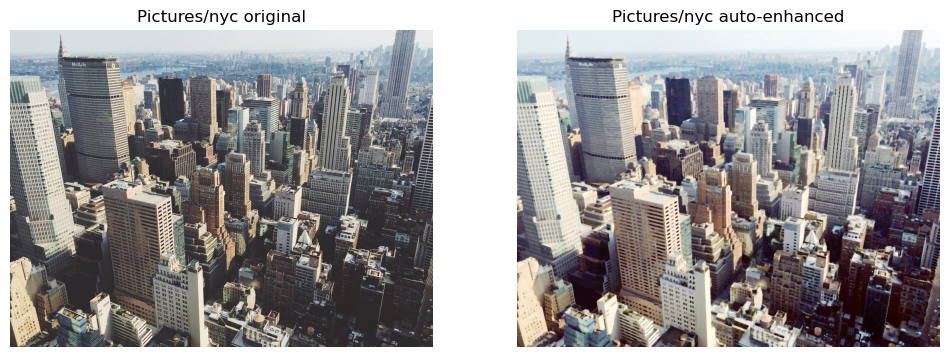

Image "Pictures/etretat": Pipeline of the image displayed below is: []
Image "Pictures/etretat": The image was estimated noisy (estimated sigma 4.688 > threshold 0.01).


100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


Image "Pictures/etretat": Image array was updated by method "equalize".
Image "Pictures/etretat": Image array was updated by method "gamma_correction".
Image "Pictures/etretat": Image array was updated by method "increase_saturation".
Image "Pictures/etretat": Pipeline of the image displayed below is: ['equalize', 'gamma_correction', 'increase_saturation']


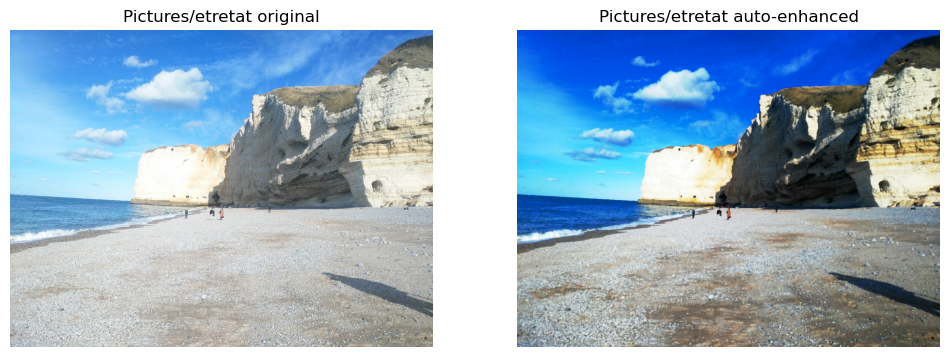

Image "Pictures/walking": Pipeline of the image displayed below is: []
Image "Pictures/walking": The image was estimated noisy (estimated sigma 0.902 > threshold 0.01).
Image "Pictures/walking": Image array was updated by method "median_filter".
Image "Pictures/walking": Image array was updated by method "equalize".
Image "Pictures/walking": Image array was updated by method "gamma_correction".
Image "Pictures/walking": Pipeline of the image displayed below is: ['median_filter', 'equalize', 'gamma_correction']


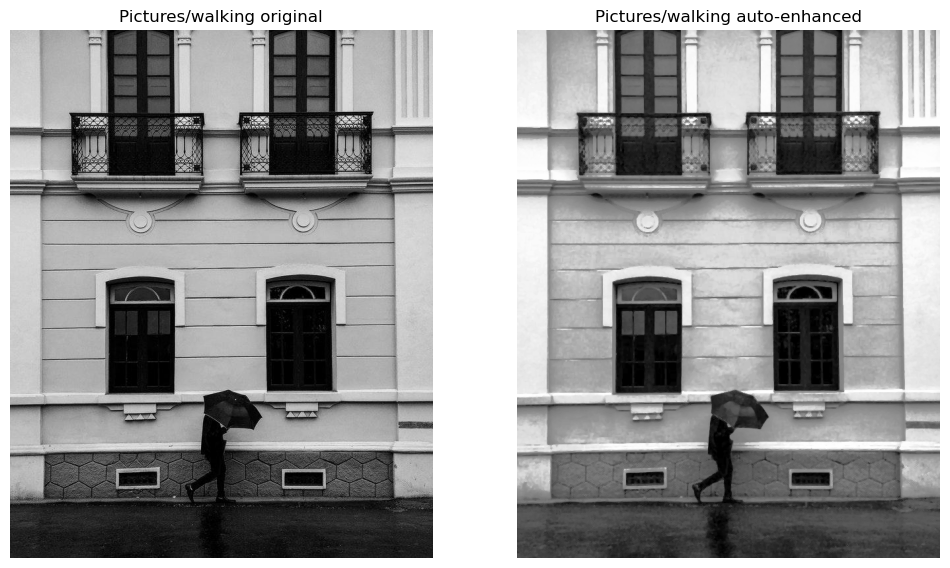

Image "Pictures/camera": Pipeline of the image displayed below is: []
Image "Pictures/camera": The image was estimated noisy (estimated sigma 0.457 > threshold 0.01).
Image "Pictures/camera": Image array was updated by method "median_filter".
Image "Pictures/camera": Image array was updated by method "equalize".
Image "Pictures/camera": Image array was updated by method "gamma_correction".
Image "Pictures/camera": Pipeline of the image displayed below is: ['median_filter', 'equalize', 'gamma_correction']


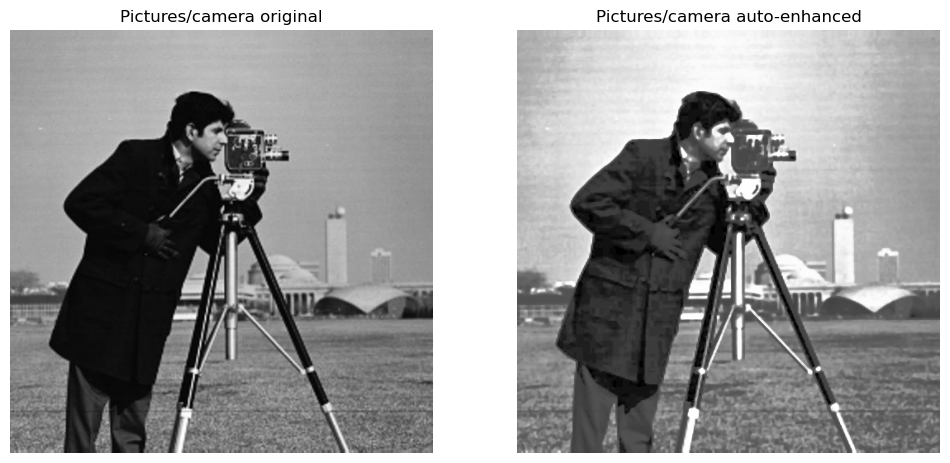

Image "Image of shape (512, 512, 3)": Pipeline of the image displayed below is: []
Image "Image of shape (512, 512, 3)": The image was estimated noisy (estimated sigma 1.92 > threshold 0.01).


100%|██████████| 3/3 [00:00<00:00, 17.49it/s]


Image "Image of shape (512, 512, 3)": Image array was updated by method "equalize".
Image "Image of shape (512, 512, 3)": Image array was updated by method "gamma_correction".
Image "Image of shape (512, 512, 3)": Image array was updated by method "increase_saturation".
Image "Image of shape (512, 512, 3)": Pipeline of the image displayed below is: ['equalize', 'gamma_correction', 'increase_saturation']


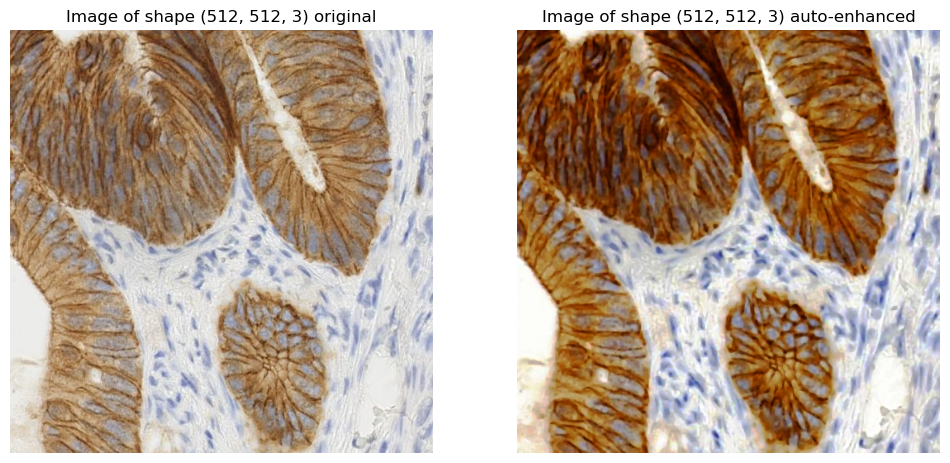

In [10]:
from skimage.data._fetchers import immunohistochemistry

path_to_image1 = 'Pictures/zebra.jpg'
path_to_image2 = 'Pictures/astronaut_noisy.jpg'
path_to_image3 = 'Pictures/nyc.jpg'
path_to_image4 = 'Pictures/etretat.jpg'
path_to_image5 = 'Pictures/walking.jpg'
path_to_image6 = 'Pictures/camera.jpg'
path_to_image7 = immunohistochemistry()

imlist = [Image(path_to_image1, chatty_mode=True), Image(path_to_image2, chatty_mode=True), Image(path_to_image3, chatty_mode=True), Image(path_to_image4, chatty_mode=True), Image(path_to_image5, chatty_mode=True), Image(path_to_image6, chatty_mode=True), Image(path_to_image7, chatty_mode=True)] 

for im in imlist:
    im.show(subplots=(1, 2, 1), size=12, title=im.name + " original")
    im.auto_enhance()
    im.show(subplots=(1, 2, 2), title=im.name + " auto-enhanced")

Image "Pictures/mri_brain": Image array was updated by method "color_to_gray".
Image "Pictures/mri_brain": Image array was updated by method "gaussian mixture segmentation".
Image "Pictures/mri_brain": Area of cluster 0: 3765 pixels
Image "Pictures/mri_brain": Area of cluster 1: 13366 pixels
Image "Pictures/mri_brain": Area of cluster 2: 6483 pixels
Image "Pictures/mri_brain": Area of cluster 3: 9708 pixels
Image "Pictures/mri_brain": Area of cluster 4: 5918 pixels
Image "Pictures/mri_brain": Pipeline of the image displayed below is: ['color_to_gray', 'gaussian mixture segmentation']


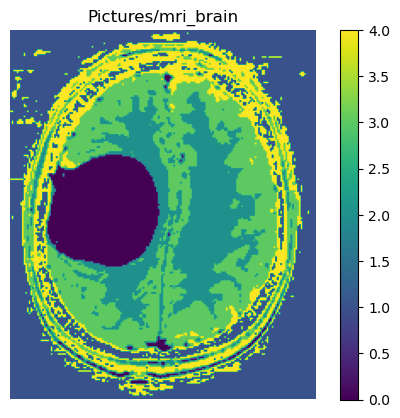

In [46]:
im = Image('Pictures/mri_brain.jpg', True)
im.color_to_gray()
areas = im.gaussian_mixture_segmentation(zones=5, iterations=1000, return_areas=True)
im.show(colorbar=True, cmap='viridis')

In [48]:
cm_by_pixel = 0.115
cm2_by_pixel2 = cm_by_pixel**2
for area in areas:
    if area == min(areas): # area of interesting zone (after looking at the output)
        print(f"Area of the tumor is estimated to {round(cm2_by_pixel2*area, 2)} cm².")

Area of the tumor is estimated to 49.79 cm².
